# Stock Price Prediction using ARIMA model

In [1]:
# Importing required libraries
import numpy as np
import pandas as pd
import datetime

from sklearn.model_selection import TimeSeriesSplit

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import plot

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

import warnings
warnings.filterwarnings('ignore')

plt.style.use("seaborn-whitegrid")
%matplotlib inline

In [2]:
# Importing datset
df = pd.read_csv("big_five_stocks.csv")

In [3]:
df.head()

,Unnamed: 0,name,open,close,high,low,volume
0,1971-02-05,^IXIC,100.00,100.00,100.00,100.00,0.0
1,1971-02-08,^IXIC,100.84,100.84,100.84,100.84,0.0
2,1971-02-09,^IXIC,100.76,100.76,100.76,100.76,0.0
3,1971-02-10,^IXIC,100.69,100.69,100.69,100.69,0.0
4,1971-02-11,^IXIC,101.45,101.45,101.45,101.45,0.0


In [4]:
df.shape

(41660, 7)

In [5]:
df.describe()

,open,close,high,low,volume
count,41660.000000,41660.000000,41660.000000,41660.000000,4.166000e+04
mean,592.565369,592.482337,596.681878,587.823401,1.195606e+07
std,1254.603123,1254.463915,1262.142541,1245.789816,2.156350e+07
min,0.090000,0.090000,0.090000,0.090000,0.000000e+00
25%,16.687500,16.727500,17.060000,16.337500,0.000000e+00
50%,89.255000,89.360000,89.875000,88.615000,2.302950e+06
75%,407.637500,407.775000,409.602500,405.975000,1.401524e+07
max,8325.100000,8330.210000,8339.640000,8291.120000,5.910786e+08


In [6]:
df.isnull().sum()

Unnamed: 0    0
name          0
open          0
close         0
high          0
low           0
volume        0
dtype: int64

In [7]:
# Formatting date column of the dataset
df["Unnamed: 0"] = pd.to_datetime(df["Unnamed: 0"])
df["year"] = df["Unnamed: 0"].dt.year
df["month"] = df["Unnamed: 0"].dt.month
df = df.rename({"Unnamed: 0" : "date"}, axis=1, inplace=False)

In [8]:
# Extracting apple stock data
apple = df[df.name == 'AAPL'].drop("name", axis=1)

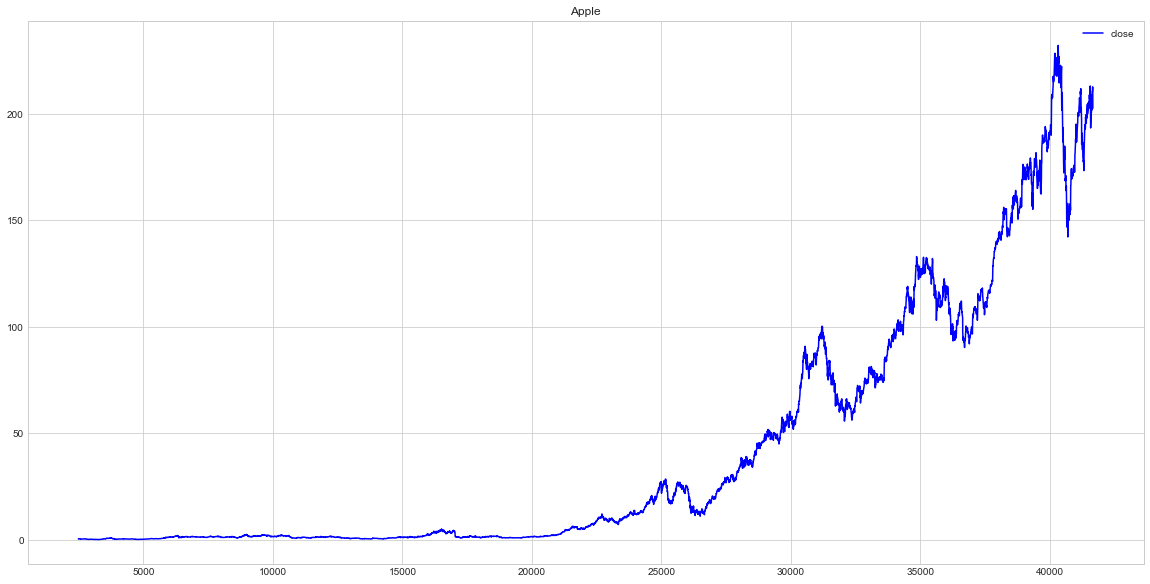

In [9]:
# Plot closing prices of apple stock data
plt.figure(figsize = (20, 10))
apple["close"].plot(color = "blue", label="close")
plt.title("Apple")
plt.legend()
plt.show()

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

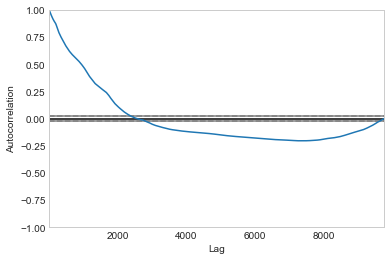

In [10]:
# Autocorrelation plot
pd.plotting.autocorrelation_plot(apple["close"])

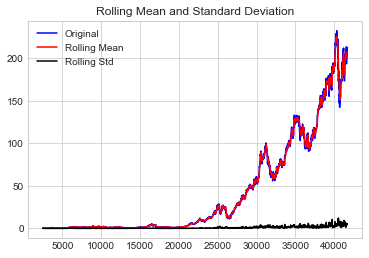

Results of dickey fuller test
Test Statistics                   2.088275
p-value                           0.998777
No. of lags used                 37.000000
Number of observations used    9722.000000
critical value (1%)              -3.431023
critical value (5%)              -2.861837
critical value (10%)             -2.566928
dtype: float64


In [11]:
def test_stationary(timeseries):
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    
    plt.plot(timeseries, color="blue", label="Original")
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

test_stationary(apple["close"])

<Figure size 432x288 with 0 Axes>

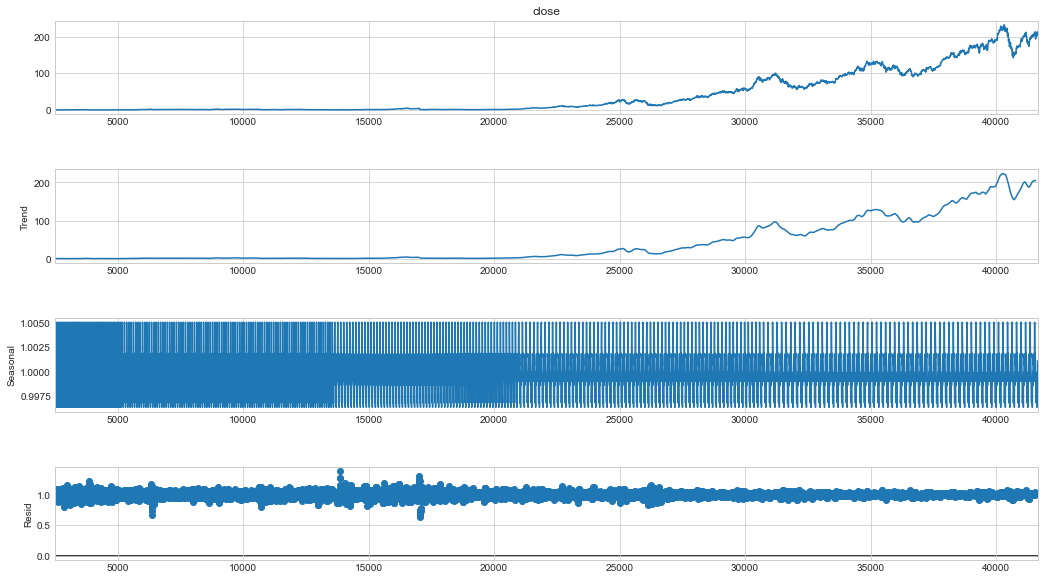

In [12]:
result = seasonal_decompose(apple["close"], model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

No handles with labels found to put in legend.


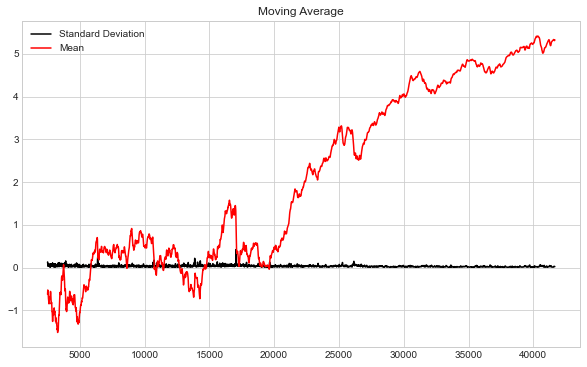

In [13]:
# Plot moving average
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(apple["close"])
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

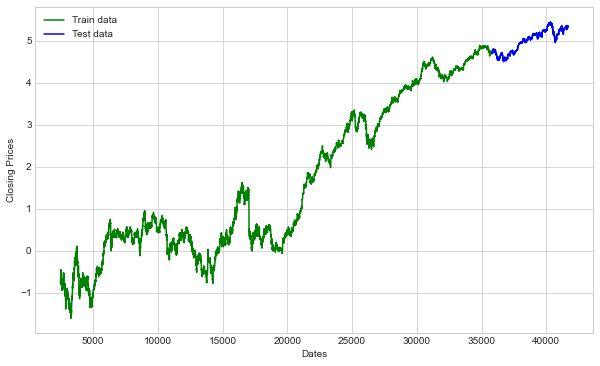

In [14]:
# Train-Test data split
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

In [15]:
# Auto ARIMA model
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-36656.992, Time=4.81 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-36664.696, Time=6.55 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-36665.161, Time=8.81 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-36655.186, Time=0.99 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-36664.920, Time=13.84 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-36667.550, Time=8.31 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-36666.442, Time=7.36 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-36669.251, Time=12.18 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-36669.013, Time=13.64 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-36667.303, Time=2.87 sec

Best model:  ARIMA(0,1,3)(0,0,0)[0] intercept
Total fit time: 79.435 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 8781
Model:               SARIMAX(0, 1, 3) 

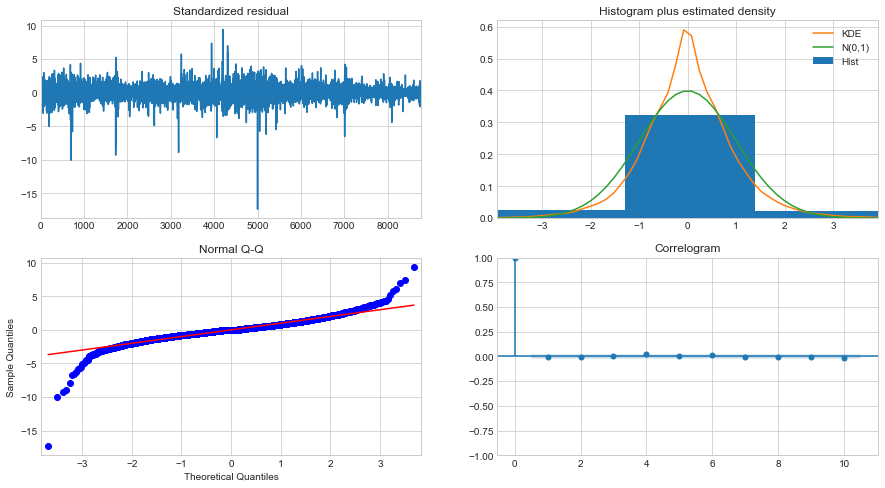

In [16]:
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [18]:
model = ARIMA(train_data, order=(3, 1, 2))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                 8780
Model:                 ARIMA(3, 1, 2)   Log Likelihood               18341.360
Method:                       css-mle   S.D. of innovations              0.030
Date:                Sun, 29 Aug 2021   AIC                         -36668.720
Time:                        11:14:53   BIC                         -36619.158
Sample:                             1   HQIC                        -36651.834
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0006      0.000      1.952      0.051   -2.66e-06       0.001
ar.L1.D.close    -0.6167      0.294     -2.095      0.036      -1.194      -0.040
ar.L2.D.close    -0.1672      0.227     

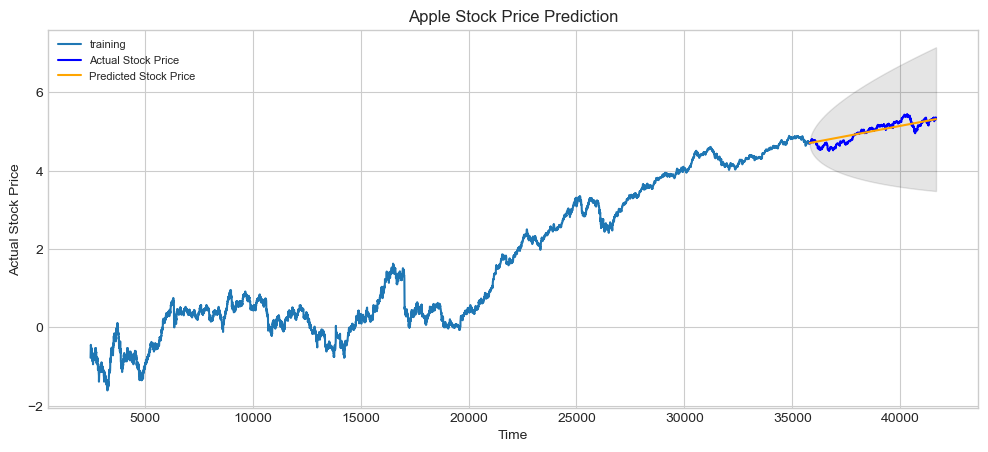

In [19]:
fc, se, conf = fitted.forecast(976, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('Apple Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [20]:
# performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.016044834759100957
MAE: 0.1023917408049443
RMSE: 0.12666820737304588
MAPE: 0.020830884203858025
